In [1]:
import casadi as ca
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

## Unscented Kalman filter

Since EKF propogate the mean and covariance of the state on the basis of the linearization, the estimation of EKF would be erroneous if the system is highly nonlinear. The unscented Kalman filter (UKF) significantly diminishes the linearization errors brought by EKF.  

The underlying idea of UKF is that we use the unscented transformation to propogate the mean and covariance of a system for each time update and measurement update, whereas the EKF uses linearization instead. 

reference: Dan Siomon, Optimal State Estimation.

### UKF alogrithm

#### Step1: Define a discrete-time nonlinear system
<center>
$$\begin{aligned} x_{k+1} &=f\left(x_{k}, u_{k}, t_{k}\right)+w_{k} \\ y_{k} &=h\left(x_{k}, t_{k}\right)+v_{k} \\ w_{k} & \sim\left(0, Q_{k}\right) \\ v_{k} & \sim\left(0, R_{k}\right), \end{aligned}$$
</center>
where the state $x_k$ is a vector with $n$ elements. The noise processes ${w_k}$ and ${v_k}$ are white, zero-mean, uncorrelated, and have known covariance matriced $Q_k$ and $R_k$.

#### Step 2: Initialize the UKF
<center>
$\begin{aligned} \hat{x}_{0}^{+} &=E\left(x_{0}\right) \\ P_{0}^{+} &=E\left[\left(x_{0}-\hat{x}_{0}^{+}\right)\left(x_{0}-\hat{x}_{0}^{+}\right)^{T}\right] \end{aligned}$    
<center>

#### Step 3: Time update
The state estimate and covriance are propogated from $\hat{x}_{k-1}$ to $\hat{x}_{k}$.

1. Choose $2n$ sigma points $\hat{x}^{(i)}_{k-1}$ for the best mean and covariance guess at time instant $k$ based on the estimation at $k-1$.
<center>
    $\begin{aligned} \hat{x}_{k-1}^{(i)} &=\hat{x}_{k-1}^{+}+\tilde{x}^{(i)} \quad i=1, \cdots, 2 n \\ \tilde{x}^{(i)} &=\left(\sqrt{n P_{k-1}^{+}}\right)_{i}^{T} \quad i=1, \cdots, n \\ \tilde{x}^{(n+i)} &=-\left(\sqrt{n P_{k-1}^{+}}\right)_{i}^{T} \quad i=1, \cdots, n \end{aligned}$
<center>

2. Tranform the simga points $\hat{x}_{k-1}^{(i)}$ into $\hat{x}^{(i)}_{k}$ vectors using the given nonlinear system $f\left(x_{k}, u_{k}, t_{k}\right)$ in the first step.
<center>
    $\hat{x}_{k}^{(i)}=f\left(\hat{x}_{k-1}^{(i)}, u_{k}, t_{k}\right)$    
<center>

3. Make a weighted average of $\hat{x}_k^{(i)}$ to acquire the the a priori state estimate at the time instant $k$ (here assigned equal weight).
<center>
    $\hat{x}_{k}^{-}=\frac{1}{2 n} \sum_{i=1}^{2 n} \hat{x}_{k}^{(i)}$
<center>

4. Update the a priori error covariance with the concideration of the process noise $Q_{k-1}$.
<center>
    $P_{k}^{-}=\frac{1}{2 n} \sum_{i=1}^{2 n}\left(\hat{x}_{k}^{(i)}-\hat{x}_{k}^{-}\right)\left(\hat{x}_{k}^{(i)}-\hat{x}_{k}^{-}\right)^{T}+Q_{k-1}$
<center>
    

#### Step 4: Measurement update

1. Choose $2n$ sigma points $\hat{x}_k^{(i)}$.
<center>
    $\begin{aligned} \hat{x}_{k}^{(i)} &=\hat{x}_{k}^{-}+\tilde{x}^{(i)} \quad i=1, \cdots, 2 n \\ \tilde{x}^{(i)} &=\left(\sqrt{n P_{k}^{-}}\right)_{i}^{T} \quad i=1, \cdots, n \\ \tilde{x}^{(n+i)} &=-\left(\sqrt{n P_{k}^{-}}\right)_{i}^{T} \quad i=1, \cdots, n \end{aligned}$
<center>

    This step could be omitted for saving computational effort; instead, reuse the result from step 3.2. 

2. Tranform the sigma points into the predicted mearsurements $\hat{y}_k^{(i)}$.
<center>
    $\hat{y}_{k}^{(i)}=h\left(\hat{x}_{k}^{(i)}, t_{k}\right)$
    
<center>

3. 
Make a weighted average of the predicted measurements as in the step 2.3.
<center>
    $\hat{y}_{k}=\frac{1}{2 n} \sum_{i=1}^{2 n} \hat{y}_{k}^{(i)}$
<center>

4. Estimate the covavriance of the predicted measurement with the consideration of the measurement noise $R_k$.
<center>
$P_{y}=\frac{1}{2 n} \sum_{i=1}^{2 n}\left(\hat{y}_{k}^{(i)}-\hat{y}_{k}\right)\left(\hat{y}_{k}^{(i)}-\hat{y}_{k}\right)^{T}+R_{k}$
<center>

5. Estimate the cross covariance between $\hat{x}_{k}^{-}$ and $\hat{y}_{k}$.
<center>
$P_{x y}=\frac{1}{2 n} \sum_{i=1}^{2 n}\left(\hat{x}_{k}^{(i)}-\hat{x}_{k}^{-}\right)\left(\hat{y}_{k}^{(i)}-\hat{y}_{k}\right)^{T}$
<center>

6. Update the a posteriori estimate.
<center>
    $\begin{aligned} K_{k} &=P_{x y} P_{y}^{-1} \\ \hat{x}_{k}^{+} &=\hat{x}_{k}^{-}+K_{k}\left(y_{k}-\hat{y}_{k}\right) \\ P_{k}^{+} &=P_{k}^{-}-K_{k} P_{y} K_{k}^{T} \end{aligned}$
<center>

In [2]:
def RK4_ca(f, x, u, t, h):
    """
    Runge-Kutta 4th order solver using casadi.

    Args:
        f: First order ODE in casadi function (Nx + Nt -> Nx).
        x: Current value (list or numpy array). 
        t: Current time.
        h: Step length.
    Returns:
        x_next: Vector of next value in casadi DM
    """
    k1 = f(x, u, t)
    k2 = f(x + h / 2 * k1, u, t + h / 2)
    k3 = f(x + h / 2 * k2, u, t + h / 2)
    k4 = f(x + h * k3, u, t + h)
    x_next = x + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [3]:
def UKF(f, h, x0, P0, Q0, y1, u1, t1, R1):
    '''
    Unscented Kalman filter. Update the estimate for the step k by using 
    the estimate at the step k-1. Footnote 0 means the value of the last step,
    and 1 means the value of the current step.
    
    Args:
    
        f: Nominal time discrete function in casadi.Function 
           (x_k, u_k, t_k -> x_{k+1}). 
        h: Nominal measurement function in casadi.Function.
           (x_k, t_k -> y_k).
        x0: State estimate of the last step (x_{k-1}).
        P0: Covariance Estimate of the last step (P_{k-1}).
        Q0: Covariance matrix of the process noises of the last step Q_{k-1}.
        y1: Measurement at the step k.
        u1: Input at the step k.
        t1: Time at the step k.
        R1: Covariance matrix of the measurement noises of the current step.

    TODO:
        1. P may need to be symmetrized: (P+P.T)/2
        2. 
    
    Return:
        x1_aposteriori: A posteriori estimate of the state
        P1_aposteriori: A posteriori estimate of the covariance matrix
    '''
    # Initialization
    # Transfer x0 in casadi.casadi.DM
    if isinstance(x0,list) or isinstance(x0,np.ndarray):
        x0_DM = ca.DM(x0)
    else:
        x0_DM = x0
    # Transfer P0 in casadi.casadi.DM
    if isinstance(P0,list) or isinstance(P0,np.ndarray):
        P0_DM = ca.DM(P0)
    else:
        P0_DM = P0

    Nx = x0_DM.shape[0]    
    Ny = np.shape(y1)[0]

    # TIME UPDATE
    # Choose 2n sigma points \hat{x}_{k-1}^{(i)} given the P_{k-1}^{+}
    x_tilde_matrix_temp = ca.DM(sqrtm(Nx*P0_DM)).T
    x_tilde_matrix = ca.horzcat(x_tilde_matrix_temp,-x_tilde_matrix_temp)
    x0_hat_matrix = x0_DM + x_tilde_matrix
    
    # transform the sigma points into x_k^{(i)}} 
    x1_hat_matrix = ca.DM.zeros(Nx,2*Nx)
    for i in range(2*Nx):
        x1_hat_matrix[:,i] = f(x0_hat_matrix[:,i], u1, t1)
        
    # calculate the a priori state estimate 
    x1_apriori = ca.DM.zeros(Nx)
    for i in range(2*Nx):
        x1_apriori += x1_hat_matrix[:,i]
    x1_apriori = x1_apriori/(2*Nx)

    # estimate a priori error covariance
    P1_apriori = ca.DM.zeros(Nx,Nx)
    for i in range(2*Nx):
        P1_apriori += (x1_hat_matrix[:,i] - x1_apriori) @ (x1_hat_matrix[:,i] - x1_apriori).T
    P1_apriori = P1_apriori/(2*Nx) + Q0

    
    #MEASUREMENT UPDATE
    # Choose 2n sigma points \hat{x}_{k}^{(i)} given the P_{k}^{-}
    x_tilde_matrix_temp = ca.DM(sqrtm(Nx*P1_apriori)).T
    x_tilde_matrix = ca.horzcat(x_tilde_matrix_temp,-x_tilde_matrix_temp)
    x1_hat_matrix = x1_apriori + x_tilde_matrix
    # transform the sigma points into y_{k}^{(i)}} 
    y1_hat_matrix = ca.DM.zeros(Ny,2*Nx)
    for i in range(2*Nx):
        y1_hat_matrix[:,i] = h(x1_hat_matrix[:,i], t1)
    
    y1_hat = ca.DM.zeros(Ny)
    for i in range(2*Nx):
        y1_hat += y1_hat_matrix[:,i]
    y1_hat = y1_hat/(2*Nx)    
    
    
    # Covariance estimate
    Py = ca.DM.zeros(Ny,Ny)
    for i in range(2*Nx):
        Py += (y1_hat_matrix[:,i] - y1_hat) @ (y1_hat_matrix[:,i] - y1_hat).T
    Py = Py/(2*Nx) + R1

    Pxy = ca.DM.zeros(Nx,Ny)
    for i in range(2*Nx):
        Pxy += (x1_hat_matrix[:,i] - x1_apriori) @ (y1_hat_matrix[:,i] - y1_hat).T
    Pxy = Pxy/(2*Nx) 

    
    # a posteriori estimate
    K1 =  Pxy @ np.linalg.inv(Py)
    x1_aposteriori = x1_apriori + K1 @ (y1 - y1_hat)
    P1_aposteriori = P1_apriori - K1 @ Py @ K1.T

    return x1_aposteriori, P1_aposteriori

In [4]:
def ca_to_list_1d(ca_data):
    return np.array(ca_data).reshape(1, -1).flatten().tolist()

#### Example: Range meansurement 
(From the book optimal state estimation, Page 451)
<center>
$\begin{aligned} x_{1} &=x_{2}+w_{1} \\ \dot{x}_{2} &=\rho_{0} \exp \left(-x_{1} / k\right) x_{2}^{2} x_{3} / 2-g+w_{2} \\ \dot{x}_{3} &=w_{3} \\ y\left(t_{k}\right) &=\sqrt{M^{2}+\left(x_{1}\left(t_{k}\right)-a\right)^{2}}+v_{k} \end{aligned}$
<center>

In [5]:
def ode_nominal(x, u, t):
    """
    Nominal time-continuous model 
    """
    # Parameter konfiguration
    rho_0 = 2    # [1b-sec^{2}/ft^{4}]
    g = 32.2    # [ft/sec^{2}]
    k = 2e4    # [ft]
    E_v = 1e4    # [ft2]
    E_wf = 0    #
    M = 1e5    # [ft]
    a = 1e5    # [ft]

    rhs = [x[1],
           rho_0 * ca.exp(-x[0]/k) * x[1]**2 * x[2]/2 - g,
           0
           ]
    return ca.vertcat(*rhs)


In [6]:
def ode_noised(x, u, w, t):
    """
    Noised time-continuous model 
    """
    # Parameter konfiguration
    rho_0 = 2    # [1b-sec^{2}/ft^{4}]
    g = 32.2    # [ft/sec^{2}]
    k = 2e4    # [ft]
    E_v = 1e4    # [ft2]
    E_wf = 0    #
    M = 1e5    # [ft]
    a = 1e5    # [ft]

    rhs = [x[1] + w[0],
           rho_0 * ca.exp(-x[0]/k) * x[1]**2 * x[2]/2 - g + w[1],
           0 + w[2]
           ]
    return ca.vertcat(*rhs)

In [7]:
def h_nominal(x, t):
    """
    Nominal measurement function 
    """
    # Parameter konfiguration
    rho_0 = 2    # [1b-sec^{2}/ft^{4}]
    g = 32.2    # [ft/sec^{2}]
    k = 2e4    # [ft]
    E_v = 1e4    # [ft2]
    E_wf = 0    #
    M = 1e5    # [ft]
    a = 1e5    # [ft]

    rhs = [ca.sqrt(M**2 + (x[0] - a)**2)
           ]
    return ca.vertcat(*rhs)


In [8]:
def h_noise(x, v, t):
    """
    Noised measurement function 
    """
    # Parameter konfiguration
    rho_0 = 2    # [1b-sec^{2}/ft^{4}]
    g = 32.2    # [ft/sec^{2}]
    k = 2e4    # [ft]
    E_v = 1e4    # [ft2]
    E_wf = 0    #
    M = 1e5    # [ft]
    a = 1e5    # [ft]

    rhs = [ca.sqrt(M**2 + (x[0] - a)**2) + v[0]
           ]
    return ca.vertcat(*rhs)

In [9]:
# Initialization

x0 = np.array([3e5,-2e4,1e-3])
f=1
P0= ca.diag([1e6,4e6,10])
P0= ca.diag([10,10,10])
Q0=ca.diag([0,0,0])
R1=ca.diag(1e4)
t1= 1
u1 = 1
mu_v = 0
sigma_v = ca.sqrt(R1)[0] 

w = [0,0,0]

In [10]:
Nx = 3    # x dimension: 3
Nt = 1    # t dimension: 1
Nu = 0
Nw = 3
Nv = 1


x_var = ca.SX.sym('x', Nx)
t_var = ca.SX.sym('t', Nt)
u_var = ca.SX.sym('u', Nu)
w_var = ca.SX.sym('w', Nw)
v_var = ca.SX.sym('t', Nv)

# Construct a casadi function for the ODE
fn_ca = ca.Function("ode_func", [x_var,u_var,t_var], [ode_nominal(x_var,u_var,t_var)])
fn_noised_ca = ca. Function("ode_noised_func", [x_var, u_var,  t_var],[ode_noised(x_var, u_var, w_var, t_var)]) ##
hn_ca = ca.Function("measurement_func", [x_var, t_var], [h_nominal(x_var,t_var)])
hn_noised_ca = ca.Function("measurement_noised_func", [x_var, v_var, t_var], [h_noise(x_var, v_var, t_var)])

# Length for each step
h = 1e-3    # Simulation 1ms
h_est = 0.5    # Obstain measurement every 0.5 s

fn_dis = ca.Function("ode_disc", [x_var,u_var,t_var], [RK4_ca(fn_ca, x_var, u_var, t_var, h)])
fn_est_dis = fn_dis = ca.Function("ode_disc", [x_var,u_var,t_var], [RK4_ca(fn_ca, x_var, u_var, t_var, h_est)])
# Generate the noised time-discrete system with step length equal to 0.5 s.
fn_noised_dis = ca.Function("ode_disc", [x_var,u_var, w_var,t_var], [RK4_ca(fn_noised_ca, x_var, u_var, t_var, h)])

In [11]:
# Empyt list to be plotted.
x_real_plot = []
x_estimate_plot = []
y_plot = []

x1_real = x0
x_real_plot.append(ca_to_list_1d(x1_real))
x_estimate_plot.append(ca_to_list_1d(x0))

t_sim = 30    # Simulation time
step_sim = int(t_sim / h)   # Simulation steps
step_sample = int(h_est / h)    # Every 0.5 seconds make a sample => 500 steps
for i in range(step_sim):
    x1_real = fn_noised_dis(x1_real,1,w,1)
    x_real_plot.append(ca_to_list_1d(x1_real))
    if i % step_sample == 0 and i != 0:    # Avoid taking the initial value twite
        v_noise = np.random.normal(mu_v, sigma_v, 1)
        y1 = hn_noised_ca(x1_real, v_noise,1)
        y_plot.append(ca_to_list_1d(y1))
        x1_estimate, P0 = UKF(fn_est_dis, hn_ca, x0, P0, Q0, y1, u1, t1, R1)
        x_estimate_plot.append(ca_to_list_1d(x1_estimate))
        x0 = x1_estimate

In [12]:
t_est = [ _* step_sample for _ in range(np.shape(x_estimate_plot)[0])]

print(np.shape(x_estimate_plot)[0])
# plt.plot(t,np.array(x_estimate_plot)[:,0])

t_real = np.arange(step_sim+1)
# plt.plot(t,np.array(x_real_plot)[:,0])

60


In [13]:
diff =np.abs( np.array(x_real_plot)[::500][:-1] - np.array(x_estimate_plot))
# t = [_*300 for _ in range(np.shape(x_estimate_plot)[0])
# print(diff)

# plt.plot(t,diff)

In [14]:
def plot_tex_setting():
    plt.rc('text.latex', preamble=r'\usepackage{amsmath}')  # für \text{..}
    plt.rcParams['text.usetex'] = True
    # plt.rcParams['figure.subplot.bottom'] = .265
    plt.rcParams['figure.subplot.bottom'] = .265
    plt.rcParams['figure.subplot.left'] = .21
    plt.rcParams['figure.subplot.top'] = .995
    plt.rcParams['figure.subplot.right'] = .98

    plt.rcParams['figure.subplot.hspace'] = .5  # vertikaler Abstand
    plt.rcParams['figure.subplot.wspace'] = .5  # horizontaler Abstand
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.labelsize'] = 13

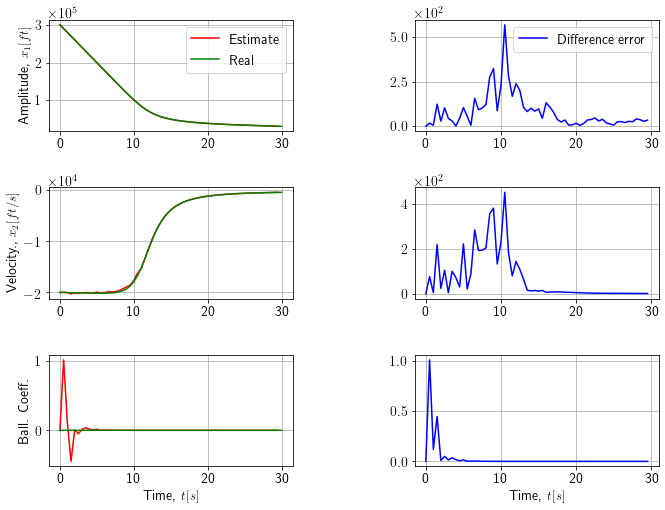

In [15]:
plot_tex_setting()
fig = plt.figure(figsize=(11, 8.5))
spec=fig.add_gridspec(nrows=3,ncols=2,height_ratios=[1,1,1])
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])

ax4 = fig.add_subplot(spec[0,1])
ax5 = fig.add_subplot(spec[1,1])
ax6 = fig.add_subplot(spec[2,1])


ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax3.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax4.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax5.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax6.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax1.plot(t_est,np.array(x_estimate_plot)[:,0],zorder = 4,color ='r',label=r'{\fontsize{14}{8}\selectfont Estimate}')
ax2.plot(t_est,np.array(x_estimate_plot)[:,1],zorder = 4,color ='r')
ax3.plot(t_est,np.array(x_estimate_plot)[:,2],zorder = 4,color ='r')

ax1.plot(t_real,np.array(x_real_plot)[:,0],zorder = 4,color ='g',label=r'{\fontsize{14}{8}\selectfont Real}')
ax2.plot(t_real,np.array(x_real_plot)[:,1],zorder = 4,color ='g')
ax3.plot(t_real,np.array(x_real_plot)[:,2],zorder = 4,color ='g')

ax4.plot(t_est,diff[:,0],zorder = 4,color ='b',label=r'{\fontsize{14}{8}\selectfont Difference error}')
ax5.plot(t_est,diff[:,1],zorder = 4,color ='b')
ax6.plot(t_est,diff[:,2],zorder = 4,color ='b')

labels = [0,10,20,30]
ax1.set_xticks([0,10000,20000,30000])
ax2.set_xticks([0,10000,20000,30000])
ax3.set_xticks([0,10000,20000,30000])
ax4.set_xticks([0,10000,20000,30000])
ax5.set_xticks([0,10000,20000,30000])
ax6.set_xticks([0,10000,20000,30000])

ax1.set_xticklabels(labels, fontdict=None, minor=False)
ax2.set_xticklabels(labels, fontdict=None, minor=False)
ax3.set_xticklabels(labels, fontdict=None, minor=False)
ax4.set_xticklabels(labels, fontdict=None, minor=False)
ax5.set_xticklabels(labels, fontdict=None, minor=False)
ax6.set_xticklabels(labels, fontdict=None, minor=False)

ax1.set_ylabel(r'{\fontsize{14}{8}\selectfont Amplitude, }$x_1[ft]$ ')
ax2.set_ylabel(r'{\fontsize{14}{8}\selectfont Velocity., }$x_2[ft/s]$ ')
ax3.set_ylabel(r'{\fontsize{14}{8}\selectfont Ball. Coeff.} ')
ax3.set_xlabel(r'{\fontsize{14}{8}\selectfont Time, }$t[s]$ ')
ax6.set_xlabel(r'{\fontsize{14}{8}\selectfont Time, }$t[s]$ ')

ax1.legend(loc="upper right")
ax4.legend(loc="upper right")

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
ax5.grid(True)
ax6.grid(True)

plt.show()

"It is seen that the altitude and velocity estimates both spike
around 10 seconds, at which point the altitude of the measuring device and
the falling body are about the same, so the measurement gives less information
about the body's altitude and velocity"

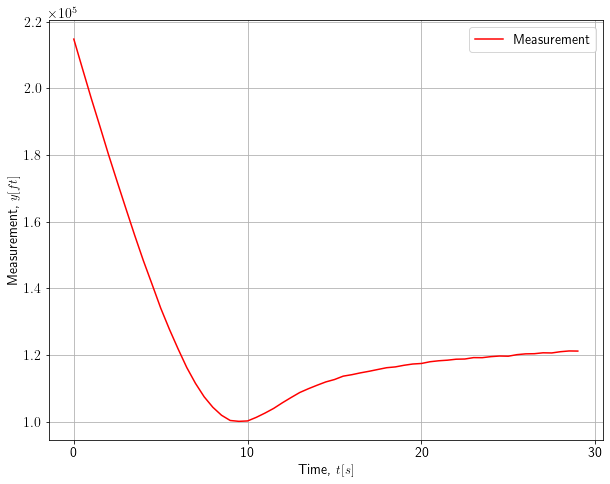

In [17]:
fig = plt.figure(figsize=(10, 8))
spec=fig.add_gridspec(nrows=1,ncols=1)
ax1 = fig.add_subplot(spec[0,0])

ax1.plot(t_est[:-1],y_plot,zorder = 4,color ='r',label=r'{\fontsize{14}{8}\selectfont Measurement}')

ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

labels = [0,10,20,30]
ax1.set_xticks([0,10000,20000,30000])
ax1.set_xticklabels(labels, fontdict=None, minor=False)

ax1.set_ylabel(r'{\fontsize{14}{8}\selectfont Measurement, }$y[ft]$ ')
ax1.set_xlabel(r'{\fontsize{14}{8}\selectfont Time, }$t[s]$ ')
ax1.legend(loc="upper right")
ax1.grid(True)